# Agrupamento de dados com o algoritmo K-means

O Agrupamento k-means é um método de Clustering que objetiva particionar n observações dentre k grupos onde cada observação pertence ao grupo mais próximo da média. Isso resulta em uma divisão do espaço de dados em um Diagrama de Voronoi.

O problema é computacionalmente difícil (NP-difícil), no entanto, existem algoritmos heurísticos eficientes que são comumente empregados e convergem rapidamente para um local optimum. Estes são geralmente semelhantes ao algoritmo de maximização da expectativa para misturas de distribuições gaussianas através de uma abordagem de refinamento iterativo utilizado por ambos os algoritmos. Além disso, ambos usam os centros de clusters para modelar dados, no entanto, a clusterização k-means tende a encontrar clusters de extensão espacial comparáveis enquanto o mecanismo de maximização da expectativa permite ter diferentes formas.

#### Neste notebook desenvolvemos o agrupamento e realizamos as análises para os grupos gerados a partir dos dados de PCA, gerados no notebook de extração de caracteristicas

In [129]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
'''
MODELO
'''
from sklearn import cluster
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

#CRIAR UM PANDA DATA FRAME
import pandas as pd
from collections import OrderedDict
import pickle

In [67]:
def salvaDataFrames_csv(dataFrame,caminhoSaida,nomeArquivo):
    dataFrame.to_csv(caminhoSaida+'\/'+nomeArquivo, sep=',', encoding = 'utf-8')
       
def salvaDataFrames_pkl(dataFrame,caminhoSaida,nomeArquivo):
    dataFrame.to_pickle(caminhoSaida+'\/'+nomeArquivo, compression='infer')
    
caminhoDataframe = 'C:\/Users\/Ricardinho\/Desktop\/notebooks_Data_Science\/DataFrames\/' 

def abreDataFrame(caminho,nomeArq):
    dataFrame = pd.read_pickle(caminho + nomeArq)#READ PICKLE MUITO IMPORTANTE!!!!!
    return dataFrame

dataFrame_SN = abreDataFrame(caminhoDataframe, 'Data_Frame_Ia_PCA_II.pkl')
dataFrame_SN.head(5)

,Nome_SN,SNx,SNy,Fase,Tipo,Tag_Fase,PCA_Px_1,PCA_Px_2,PCA_Py_1,PCA_Py_2,PCA_Vx_1,PCA_Vx_2,PCA_Vy_1,PCA_Vy_2
0,SN_Redshifted_sn1998V-19980319.flm,"[3657.8171091445433, 3661.5775067102504, 3665....","[0.5984432965698894, 0.5905492293635906, 0.579...",-1.890,Ia,Maximo,-6458.880203,-655.708442,-0.444330,0.048064,-6280.719189,-396.874182,-0.241119,0.373996
1,SN_Redshifted_sn1998V-19980320.flm,"[3657.8171091445433, 3661.5775067102504, 3665....","[0.637192333491651, 0.6141274942884631, 0.5960...",-1.890,Ia,Maximo,-2137.843934,3937.730133,-0.275439,0.112216,1117.916273,4786.035450,-0.069201,0.484576
2,SN_Redshifted_sn1998V-19980321.flm,"[3657.8171091445433, 3661.546502254467, 3665.2...","[0.6570335303026084, 0.6753503669909301, 0.673...",-0.956,Ia,Maximo,-4579.883496,2143.853840,-0.423004,0.239782,-4128.202144,2893.456010,-0.306284,0.584218
3,SN_Redshifted_sn1998dx-19980914.flm,"[3529.746655280387, 3533.3753907622395, 3537.0...","[0.9510331445835957, 0.8747050414260726, 0.822...",-0.435,Ia,Maximo,3484.079226,4660.968716,-0.412396,0.413321,3706.066803,4403.288462,-0.213103,0.403622
4,SN_Redshifted_sn1998dx-19980915.flm,"[3529.746655280387, 3533.3753907622395, 3537.0...","[0.9336562914191868, 0.8202276475798798, 0.749...",-0.435,Ia,Maximo,3294.567153,4491.130144,-0.331301,0.292613,6098.139925,2879.216191,-0.138856,0.308748


In [69]:
def gerandoFeatures_DataFrame_Kmeans(dataFrame_SN,feature):
    
    '''
    dados basicos que sempre ficam no dataframe
    '''
    data1 = dataFrame_SN.loc[:,'SNx']
    data1 = data1.tolist()
    
    data2 = dataFrame_SN.loc[:,'Nome_SN']
    data2 = data2.tolist()
    
    data3 = dataFrame_SN.loc[:,'SNy']
    data3 = data3.tolist()
    
    data4 = dataFrame_SN.loc[:,'Tipo']
    data4 = data4.tolist()
    
    data5 = dataFrame_SN.loc[:,'Fase']
    data5 = data5.tolist()
    
    data6 = dataFrame_SN.loc[:,'Tag_Fase']
    data6 = data6.tolist()
    
    #gera o 1st data frame
    dataFrameFeatures = OrderedDict(
    {
     'Nome_SN':data2,
     'SNx':data1,
     'SNy':data3,
     'Tipo':data4,
     'Fase':data5,
     'Tag_Fase':data6
     })
    df = pd.DataFrame(dataFrameFeatures)
    #print(feature)
    
    feature = pd.DataFrame(feature, columns = ['Clusters-Kmeans'])
   
    dataFrame_Final = pd.concat([df,feature],axis = 1)
    
    return dataFrame_Final

In [70]:
#mudar os rotulos com nomes para numeros inteiros
#ROTULANDO COM VALORES PARA O MACHINE_LEARNING
def machine_learning_tag(dataframe):
    
    nome_valor = []
    print(dataframe.loc[0,'Tag_Fase'])
    for i in range(len(dataframe.index)):
        if(dataframe.loc[i,'Tag_Fase'] == 'Inicial'):
            valor = 1
            nome_valor.append(valor)
        elif(dataframe.loc[i,'Tag_Fase'] == 'Pre_Maximo' ):
            valor = 2
            nome_valor.append(valor)
        elif(dataframe.loc[i,'Tag_Fase'] == 'Maximo'):
            valor = 3
            nome_valor.append(valor)
        elif(dataframe.loc[i,'Tag_Fase'] == 'Pos_Maximo'):
            valor = 4
            nome_valor.append(valor)
        elif(dataframe.loc[i,'Tag_Fase'] == 'Pre_Nebular' ):
            valor = 5
            nome_valor.append(valor)
        elif(dataframe.loc[i,'Tag_Fase'] == 'Nebular' ):
            valor = 6
            nome_valor.append(valor)
        else:
            nome_valor.append(0)
                
    dataframe['Tag_valor'] = nome_valor     
    
    return nome_valor

## Computando o Kmeans para os valores de PCA de vales e de picos

In [71]:
X = dataFrame_SN[['PCA_Px_1','PCA_Px_2','PCA_Py_1','PCA_Py_2','PCA_Vx_1','PCA_Vx_2','PCA_Vy_1','PCA_Vy_2']]

X = np.asarray(X)
#labels
#y = machine_learning_tag(dataframe=dataFrame_SN)
y = dataFrame_SN[['Tag_Fase']]

Text(0.5,1,'K=6, J=28843254306.20')

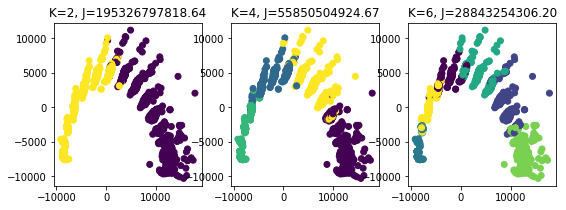

In [72]:
'''
CLUSTERING: 2,4,6
'''
km2 = cluster.KMeans(n_clusters=2).fit(X)
km4 = cluster.KMeans(n_clusters=4).fit(X)
km6 = cluster.KMeans(n_clusters=6).fit(X)

plt.figure(figsize=(9, 3))
plt.subplot(131)
plt.scatter(X[:, 0], X[:, 1], c=km2.labels_)
plt.title("K=2, J=%.2f" % km2.inertia_)
plt.subplot(132)
plt.scatter(X[:, 0], X[:, 1], c=km4.labels_)
plt.title("K=4, J=%.2f" % km4.inertia_)
plt.subplot(133)
plt.scatter(X[:, 0], X[:, 1], c=km6.labels_)#.astype(np.float))
plt.title("K=6, J=%.2f" % km6.inertia_)

In [73]:
# SALVANDO O MODELO
filename1 = 'modelo_K_2_1.sav'
pickle.dump(km2, open(filename1, 'wb'))

filename2 = 'modelo_K_4_1.sav'
pickle.dump(km4, open(filename2, 'wb'))
 
filename3 = 'modelo_K_6_1.sav'
pickle.dump(km6, open(filename3, 'wb'))

In [74]:
carrega_modelo = pickle.load(open('modelo_K_6_1.sav', 'rb'))

In [75]:
clusters = carrega_modelo.labels_

In [76]:
dataFrame_kmeans_I = gerandoFeatures_DataFrame_Kmeans(dataFrame_SN,clusters)

salvaDataFrames_csv(dataFrame_kmeans_I,caminhoDataframe,'Data_Frame_Ia_Kmeans_I.csv')
salvaDataFrames_pkl(dataFrame_kmeans_I,caminhoDataframe,'Data_Frame_Ia_Kmeans_I.pkl')

In [77]:
dataFrame_kmeans_I.head(5)

,Nome_SN,SNx,SNy,Tipo,Fase,Tag_Fase,Clusters-Kmeans
0,SN_Redshifted_sn1998V-19980319.flm,"[3657.8171091445433, 3661.5775067102504, 3665....","[0.5984432965698894, 0.5905492293635906, 0.579...",Ia,-1.890,Maximo,5
1,SN_Redshifted_sn1998V-19980320.flm,"[3657.8171091445433, 3661.5775067102504, 3665....","[0.637192333491651, 0.6141274942884631, 0.5960...",Ia,-1.890,Maximo,0
2,SN_Redshifted_sn1998V-19980321.flm,"[3657.8171091445433, 3661.546502254467, 3665.2...","[0.6570335303026084, 0.6753503669909301, 0.673...",Ia,-0.956,Maximo,0
3,SN_Redshifted_sn1998dx-19980914.flm,"[3529.746655280387, 3533.3753907622395, 3537.0...","[0.9510331445835957, 0.8747050414260726, 0.822...",Ia,-0.435,Maximo,3
4,SN_Redshifted_sn1998dx-19980915.flm,"[3529.746655280387, 3533.3753907622395, 3537.0...","[0.9336562914191868, 0.8202276475798798, 0.749...",Ia,-0.435,Maximo,3


In [78]:
#Verifica a média dos valores de fase para cada grupo
dataCluster_0 = []
dataCluster_1 = []
dataCluster_2 = []
dataCluster_3 = []
dataCluster_4 = []
dataCluster_5 = []
for i in range(len(dataFrame_kmeans_I.index)):
    if(dataFrame_kmeans_I.loc[i,'Clusters-Kmeans'] == 0):
        dataCluster_0.append(i)
    if(dataFrame_kmeans_I.loc[i,'Clusters-Kmeans'] == 1):
        dataCluster_1.append(i)
    if(dataFrame_kmeans_I.loc[i,'Clusters-Kmeans'] == 2):
        dataCluster_2.append(i)
    if(dataFrame_kmeans_I.loc[i,'Clusters-Kmeans'] == 3):
        dataCluster_3.append(i)    
    if(dataFrame_kmeans_I.loc[i,'Clusters-Kmeans'] == 4):
        dataCluster_4.append(i)
    if(dataFrame_kmeans_I.loc[i,'Clusters-Kmeans'] == 5):
        dataCluster_5.append(i)    

## Verificando as fases médias de cada grupo gerado

In [102]:
def guarda_fases(data_cluster,dataframe):
    data_fase = []
    for i in range(len(data_cluster)):
        data_fase.append(dataframe.loc[data_cluster[i],'Fase'])
    return data_fase    

def plotar_fases_clusters(data_cluster,dataframe):
    for i in range(10):
        plt.plot(dataframe.loc[data_cluster[i],'SNx'],dataframe.loc[data_cluster[i],'SNy'])

## Análise dos Grupos Formados

In [80]:
fases_cluster_0 = guarda_fases(dataCluster_0,dataFrame_kmeans_I)
fases_cluster_1 = guarda_fases(dataCluster_1,dataFrame_kmeans_I)
fases_cluster_2 = guarda_fases(dataCluster_2,dataFrame_kmeans_I)
fases_cluster_3 = guarda_fases(dataCluster_3,dataFrame_kmeans_I)
fases_cluster_4 = guarda_fases(dataCluster_4,dataFrame_kmeans_I)
fases_cluster_5 = guarda_fases(dataCluster_5,dataFrame_kmeans_I)

fase_0 = pd.Series(fases_cluster_0)
fase_1 = pd.Series(fases_cluster_1)
fase_2 = pd.Series(fases_cluster_2)
fase_3 = pd.Series(fases_cluster_3)
fase_4 = pd.Series(fases_cluster_4)
fase_5 = pd.Series(fases_cluster_5)

Current size: [6.0, 4.0]


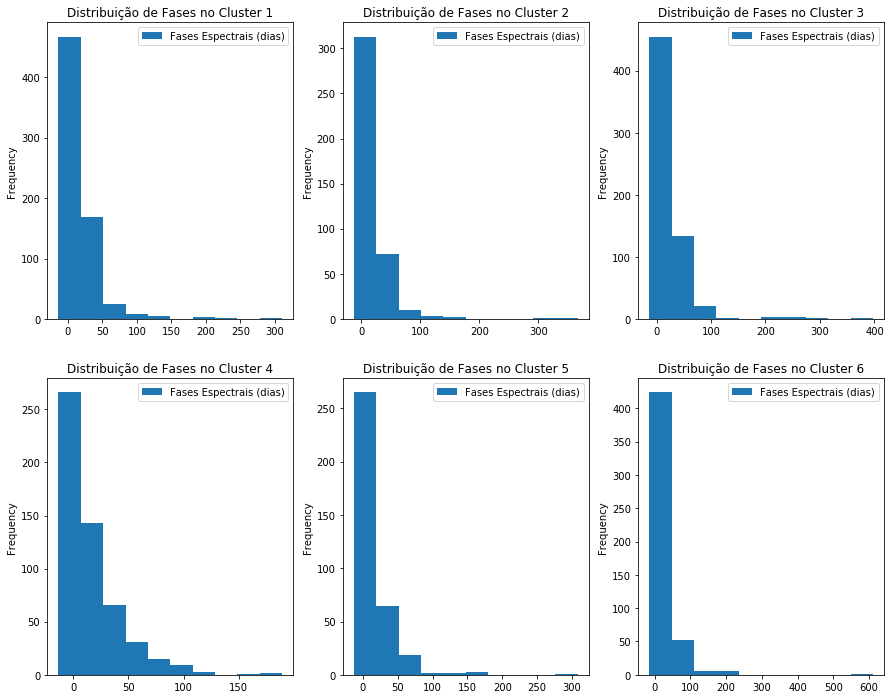

In [93]:
# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Prints: [8.0, 6.0]
print ("Current size:", fig_size)
 
# Set figure width to 12 and height to 9
fig_size[0] = 15
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size

fig, axes = plt.subplots(nrows=2, ncols=3)
fase_0.plot(ax=axes[0,0],kind='hist',title='Distribuição de Fases no Cluster 1',legend = True,label='Fases Espectrais (dias)')
fase_1.plot(ax=axes[0,1],kind='hist',title='Distribuição de Fases no Cluster 2',legend = True,label='Fases Espectrais (dias)')
fase_2.plot(ax=axes[0,2],kind='hist',title='Distribuição de Fases no Cluster 3',legend = True,label='Fases Espectrais (dias)')
fase_3.plot(ax=axes[1,0],kind='hist',title='Distribuição de Fases no Cluster 4',legend = True,label='Fases Espectrais (dias)')
fase_4.plot(ax=axes[1,1],kind='hist',title='Distribuição de Fases no Cluster 5',legend = True,label='Fases Espectrais (dias)')
fase_5.plot(ax=axes[1,2],kind='hist',title='Distribuição de Fases no Cluster 6',legend = True,label='Fases Espectrais (dias)')



Neste grupo a distribuição de fases indica que ainda existe uma forte correlação entre os espectros, isto é, espectros de caracteristicas diferentes foram agrupados e isto é visto pela distribuição dos valores de fases, em cada grupo existe um valor alto para as fases de 0 ~ 50 dias.

## Verificando as fases

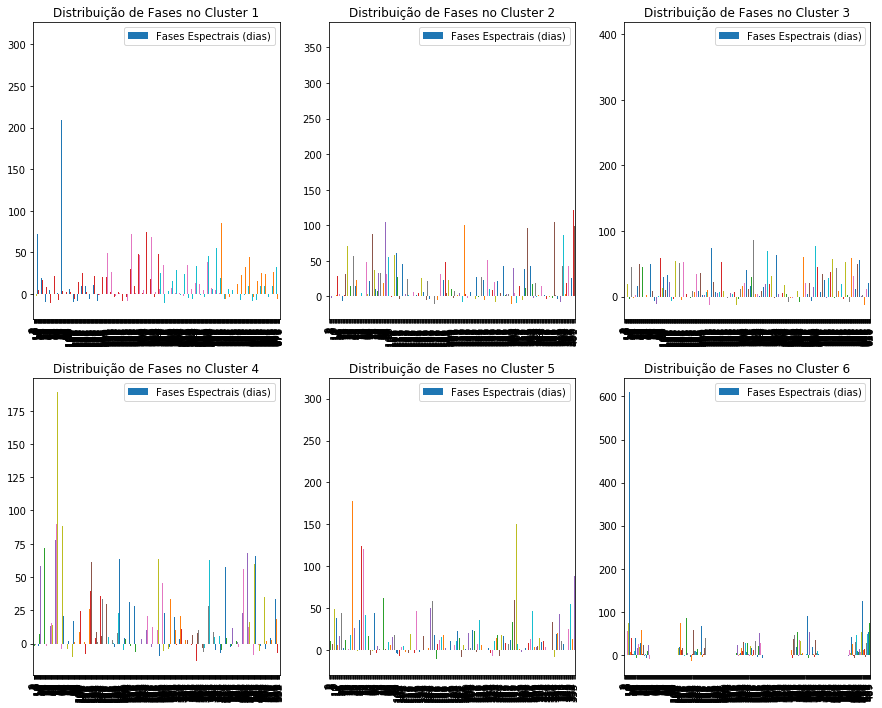

In [114]:
fig, axes = plt.subplots(nrows=2, ncols=3)

fase_0.plot(ax=axes[0,0],kind='bar',title='Distribuição de Fases no Cluster 1',legend = True,label='Fases Espectrais (dias)')
fase_1.plot(ax=axes[0,1],kind='bar',title='Distribuição de Fases no Cluster 2',legend = True,label='Fases Espectrais (dias)')
fase_2.plot(ax=axes[0,2],kind='bar',title='Distribuição de Fases no Cluster 3',legend = True,label='Fases Espectrais (dias)')
fase_3.plot(ax=axes[1,0],kind='bar',title='Distribuição de Fases no Cluster 4',legend = True,label='Fases Espectrais (dias)')
fase_4.plot(ax=axes[1,1],kind='bar',title='Distribuição de Fases no Cluster 5',legend = True,label='Fases Espectrais (dias)')
fase_5.plot(ax=axes[1,2],kind='bar',title='Distribuição de Fases no Cluster 6',legend = True,label='Fases Espectrais (dias)')


### Verificando os modelos de supernovas gerados pelo agrupamento kmeans

Text(0.5,1,'Modelos de Supernova no Cluster 6')

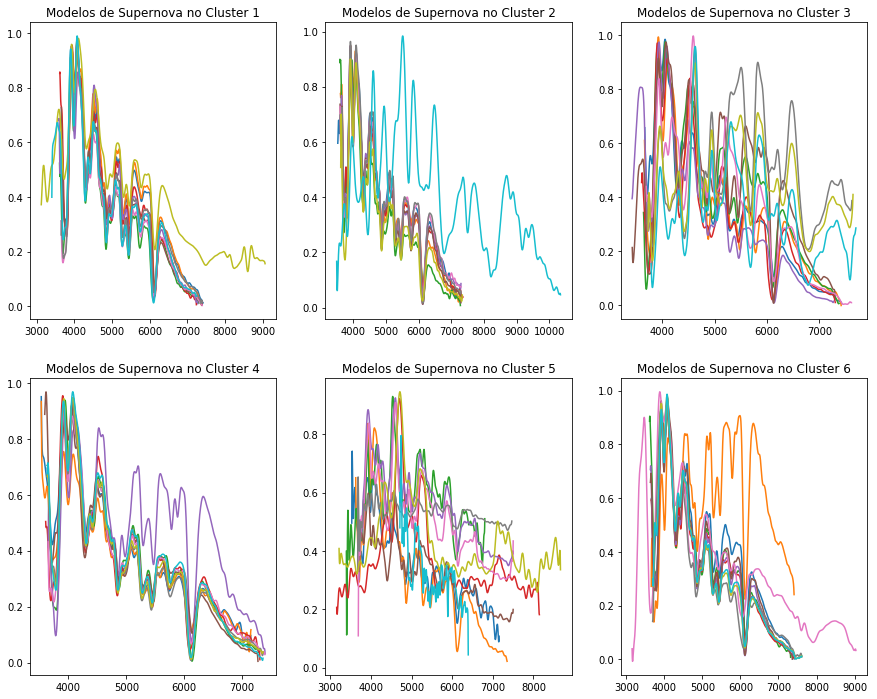

In [112]:
fig, axes = plt.subplots(nrows=2, ncols=3)
for i in range(10):
    axes[0,0].plot(dataFrame_kmeans_I.loc[dataCluster_0[i],'SNx'],dataFrame_kmeans_I.loc[dataCluster_0[i],'SNy'])
    axes[0,1].plot(dataFrame_kmeans_I.loc[dataCluster_1[i],'SNx'],dataFrame_kmeans_I.loc[dataCluster_1[i],'SNy'])
    axes[0,2].plot(dataFrame_kmeans_I.loc[dataCluster_2[i],'SNx'],dataFrame_kmeans_I.loc[dataCluster_2[i],'SNy'])
    axes[1,0].plot(dataFrame_kmeans_I.loc[dataCluster_3[i],'SNx'],dataFrame_kmeans_I.loc[dataCluster_3[i],'SNy'])
    axes[1,1].plot(dataFrame_kmeans_I.loc[dataCluster_4[i],'SNx'],dataFrame_kmeans_I.loc[dataCluster_4[i],'SNy'])
    axes[1,2].plot(dataFrame_kmeans_I.loc[dataCluster_5[i],'SNx'],dataFrame_kmeans_I.loc[dataCluster_5[i],'SNy'])
    
axes[0,0].set_title('Modelos de Supernova no Cluster 1')
axes[0,1].set_title('Modelos de Supernova no Cluster 2')
axes[0,2].set_title('Modelos de Supernova no Cluster 3')
axes[1,0].set_title('Modelos de Supernova no Cluster 4')
axes[1,1].set_title('Modelos de Supernova no Cluster 5')
axes[1,2].set_title('Modelos de Supernova no Cluster 6')

O agrupamento pelo Kmeans não possui um bom desempenho neste caso. O agrupamento pelo Kmeans gerou grupos muito hetereogeneos e diversos, ou seja, espectros diferentes foram agrupados em conjunto.

## Computando o Kmeans para os valores de PCA de comprimento de onda e de fluxo de radiação

In [115]:
dataFrame_PCA_XY = abreDataFrame(caminhoDataframe, 'Data_Frame_Ia_PCA_XY.pkl')
dataFrame_PCA_XY.head(5)

,Nome_SN,SNx,SNy,Fase,Tipo,Tag_Fase,PCA_SNx_1,PCA_SNx_2,PCA_SNx_3,PCA_SNx_4,PCA_SNy_1,PCA_SNy_2,PCA_SNy_3,PCA_SNy_4
0,SN_Redshifted_sn1998V-19980319.flm,"[3657.8171091445433, 3661.5775067102504, 3665....","[0.5984432965698894, 0.5905492293635906, 0.579...",-1.890,Ia,Maximo,1067.728793,1559.146097,7.421434e-10,-3.382472e-12,-3.989887,-1.327662,-1.906058,1.198017
1,SN_Redshifted_sn1998V-19980320.flm,"[3657.8171091445433, 3661.5775067102504, 3665....","[0.637192333491651, 0.6141274942884631, 0.5960...",-1.890,Ia,Maximo,1067.728793,1559.146097,7.409506e-10,1.220192e-11,-4.102365,-1.263241,-1.900481,1.228636
2,SN_Redshifted_sn1998V-19980321.flm,"[3657.8171091445433, 3661.546502254467, 3665.2...","[0.6570335303026084, 0.6753503669909301, 0.673...",-0.956,Ia,Maximo,503.000753,1591.195877,7.456314e-10,-7.024128e-14,-3.939491,-1.560221,-2.191264,0.987669
3,SN_Redshifted_sn1998dx-19980914.flm,"[3529.746655280387, 3533.3753907622395, 3537.0...","[0.9510331445835957, 0.8747050414260726, 0.822...",-0.435,Ia,Maximo,-4946.086051,-129.305816,7.446961e-10,-1.072000e-12,-4.463030,-1.872636,1.136015,0.552185
4,SN_Redshifted_sn1998dx-19980915.flm,"[3529.746655280387, 3533.3753907622395, 3537.0...","[0.9336562914191868, 0.8202276475798798, 0.749...",-0.435,Ia,Maximo,-4946.086051,-129.305816,7.446961e-10,-1.072000e-12,-3.999763,-0.583957,1.597298,0.534887


In [116]:
X = dataFrame_PCA_XY[['PCA_SNx_1', 'PCA_SNx_2','PCA_SNx_3', 'PCA_SNx_4','PCA_SNy_1', 'PCA_SNy_2','PCA_SNy_3', 'PCA_SNy_4']]
X = np.asarray(X)
#labels
y = dataFrame_PCA_XY[['Tag_Fase']]

Text(0.5,1,'K=6, J=23013938482.73')

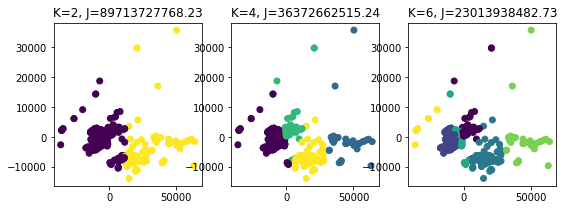

In [117]:
'''
CLUSTERING: 2,4,6
'''
km2 = cluster.KMeans(n_clusters=2).fit(X)
km4 = cluster.KMeans(n_clusters=4).fit(X)
km6 = cluster.KMeans(n_clusters=6).fit(X)

plt.figure(figsize=(9, 3))
plt.subplot(131)
plt.scatter(X[:, 0], X[:, 1], c=km2.labels_)
plt.title("K=2, J=%.2f" % km2.inertia_)
plt.subplot(132)
plt.scatter(X[:, 0], X[:, 1], c=km4.labels_)
plt.title("K=4, J=%.2f" % km4.inertia_)
plt.subplot(133)
plt.scatter(X[:, 0], X[:, 1], c=km6.labels_)#.astype(np.float))
plt.title("K=6, J=%.2f" % km6.inertia_)

In [118]:
# SALVANDO O MODELO
filename1 = 'modelo_K_2_2.sav'
pickle.dump(km2, open(filename1, 'wb'))

filename2 = 'modelo_K_4_2.sav'
pickle.dump(km4, open(filename2, 'wb'))
 
filename3 = 'modelo_K_6_2.sav'
pickle.dump(km6, open(filename3, 'wb'))


In [119]:
carrega_modelo2 = pickle.load(open('modelo_K_6_2.sav', 'rb'))

In [120]:
clusters_2 = carrega_modelo2.labels_

In [121]:
dataFrame_kmeans_2 = gerandoFeatures_DataFrame_Kmeans(dataFrame_PCA_XY,clusters_2)

salvaDataFrames_csv(dataFrame_kmeans_2,caminhoDataframe,'Data_Frame_Ia_Kmeans.csv')
salvaDataFrames_pkl(dataFrame_kmeans_2,caminhoDataframe,'Data_Frame_Ia_Kmeans.pkl')

In [122]:
dataFrame_kmeans_2.head(5)

,Nome_SN,SNx,SNy,Tipo,Fase,Tag_Fase,Clusters-Kmeans
0,SN_Redshifted_sn1998V-19980319.flm,"[3657.8171091445433, 3661.5775067102504, 3665....","[0.5984432965698894, 0.5905492293635906, 0.579...",Ia,-1.890,Maximo,0
1,SN_Redshifted_sn1998V-19980320.flm,"[3657.8171091445433, 3661.5775067102504, 3665....","[0.637192333491651, 0.6141274942884631, 0.5960...",Ia,-1.890,Maximo,0
2,SN_Redshifted_sn1998V-19980321.flm,"[3657.8171091445433, 3661.546502254467, 3665.2...","[0.6570335303026084, 0.6753503669909301, 0.673...",Ia,-0.956,Maximo,0
3,SN_Redshifted_sn1998dx-19980914.flm,"[3529.746655280387, 3533.3753907622395, 3537.0...","[0.9510331445835957, 0.8747050414260726, 0.822...",Ia,-0.435,Maximo,3
4,SN_Redshifted_sn1998dx-19980915.flm,"[3529.746655280387, 3533.3753907622395, 3537.0...","[0.9336562914191868, 0.8202276475798798, 0.749...",Ia,-0.435,Maximo,3


## Análise dos Grupos Formados

In [124]:
#Verifica a média dos valores de fase para cada grupo
dataCluster_0 = []
dataCluster_1 = []
dataCluster_2 = []
dataCluster_3 = []
dataCluster_4 = []
dataCluster_5 = []
for i in range(len(dataFrame_kmeans_2.index)):
    if(dataFrame_kmeans_2.loc[i,'Clusters-Kmeans'] == 0):
        dataCluster_0.append(i)
    if(dataFrame_kmeans_2.loc[i,'Clusters-Kmeans'] == 1):
        dataCluster_1.append(i)
    if(dataFrame_kmeans_2.loc[i,'Clusters-Kmeans'] == 2):
        dataCluster_2.append(i)
    if(dataFrame_kmeans_2.loc[i,'Clusters-Kmeans'] == 3):
        dataCluster_3.append(i)    
    if(dataFrame_kmeans_2.loc[i,'Clusters-Kmeans'] == 4):
        dataCluster_4.append(i)
    if(dataFrame_kmeans_2.loc[i,'Clusters-Kmeans'] == 5):
        dataCluster_5.append(i)   

In [125]:
fases_cluster_0 = guarda_fases(dataCluster_0,dataFrame_kmeans_2)
fases_cluster_1 = guarda_fases(dataCluster_1,dataFrame_kmeans_2)
fases_cluster_2 = guarda_fases(dataCluster_2,dataFrame_kmeans_2)
fases_cluster_3 = guarda_fases(dataCluster_3,dataFrame_kmeans_2)
fases_cluster_4 = guarda_fases(dataCluster_4,dataFrame_kmeans_2)
fases_cluster_5 = guarda_fases(dataCluster_5,dataFrame_kmeans_2)

fase_0 = pd.Series(fases_cluster_0)
fase_1 = pd.Series(fases_cluster_1)
fase_2 = pd.Series(fases_cluster_2)
fase_3 = pd.Series(fases_cluster_3)
fase_4 = pd.Series(fases_cluster_4)
fase_5 = pd.Series(fases_cluster_5)

Current size: [15.0, 12.0]


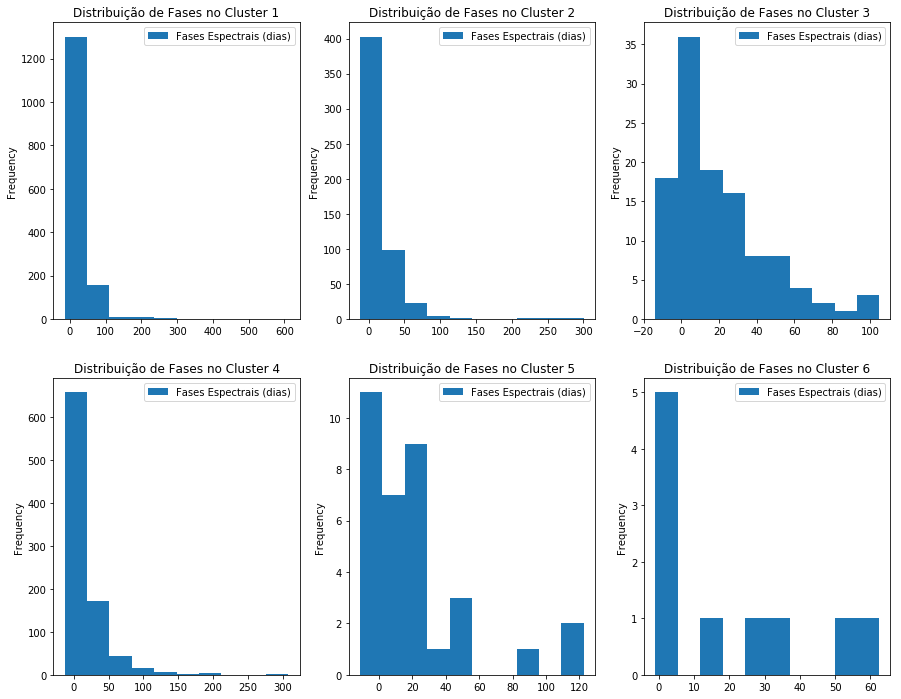

In [126]:
# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Prints: [8.0, 6.0]
print ("Current size:", fig_size)
 
# Set figure width to 12 and height to 9
fig_size[0] = 15
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size

fig, axes = plt.subplots(nrows=2, ncols=3)
fase_0.plot(ax=axes[0,0],kind='hist',title='Distribuição de Fases no Cluster 1',legend = True,label='Fases Espectrais (dias)')
fase_1.plot(ax=axes[0,1],kind='hist',title='Distribuição de Fases no Cluster 2',legend = True,label='Fases Espectrais (dias)')
fase_2.plot(ax=axes[0,2],kind='hist',title='Distribuição de Fases no Cluster 3',legend = True,label='Fases Espectrais (dias)')
fase_3.plot(ax=axes[1,0],kind='hist',title='Distribuição de Fases no Cluster 4',legend = True,label='Fases Espectrais (dias)')
fase_4.plot(ax=axes[1,1],kind='hist',title='Distribuição de Fases no Cluster 5',legend = True,label='Fases Espectrais (dias)')
fase_5.plot(ax=axes[1,2],kind='hist',title='Distribuição de Fases no Cluster 6',legend = True,label='Fases Espectrais (dias)')


## Verificando as Fases

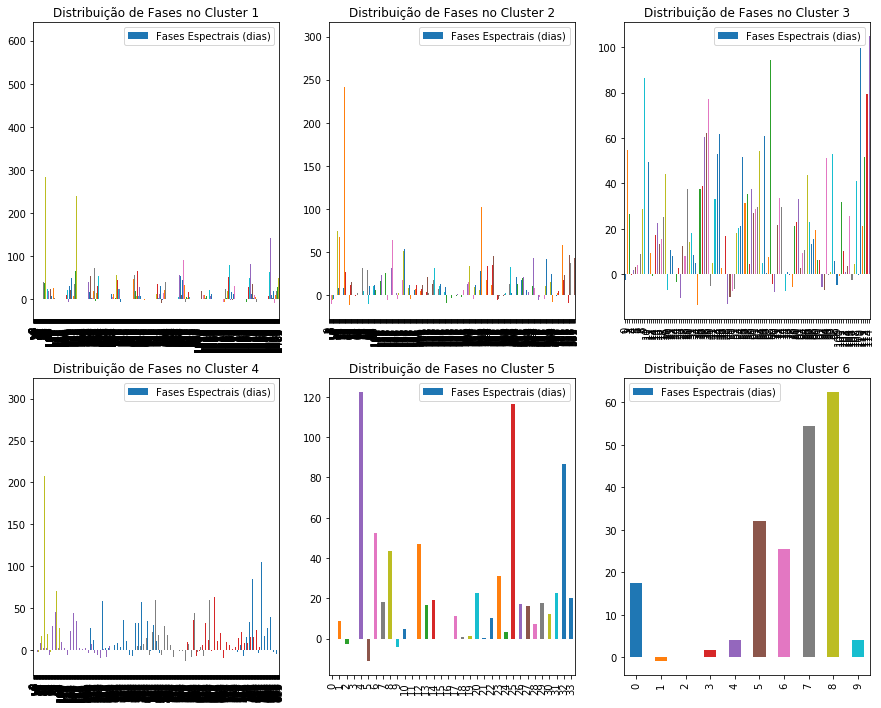

In [127]:
fig, axes = plt.subplots(nrows=2, ncols=3)

fase_0.plot(ax=axes[0,0],kind='bar',title='Distribuição de Fases no Cluster 1',legend = True,label='Fases Espectrais (dias)')
fase_1.plot(ax=axes[0,1],kind='bar',title='Distribuição de Fases no Cluster 2',legend = True,label='Fases Espectrais (dias)')
fase_2.plot(ax=axes[0,2],kind='bar',title='Distribuição de Fases no Cluster 3',legend = True,label='Fases Espectrais (dias)')
fase_3.plot(ax=axes[1,0],kind='bar',title='Distribuição de Fases no Cluster 4',legend = True,label='Fases Espectrais (dias)')
fase_4.plot(ax=axes[1,1],kind='bar',title='Distribuição de Fases no Cluster 5',legend = True,label='Fases Espectrais (dias)')
fase_5.plot(ax=axes[1,2],kind='bar',title='Distribuição de Fases no Cluster 6',legend = True,label='Fases Espectrais (dias)')


### Modelos Gerados Neste novo Agrupamento

Text(0.5,1,'Modelos de Supernova no Cluster 6')

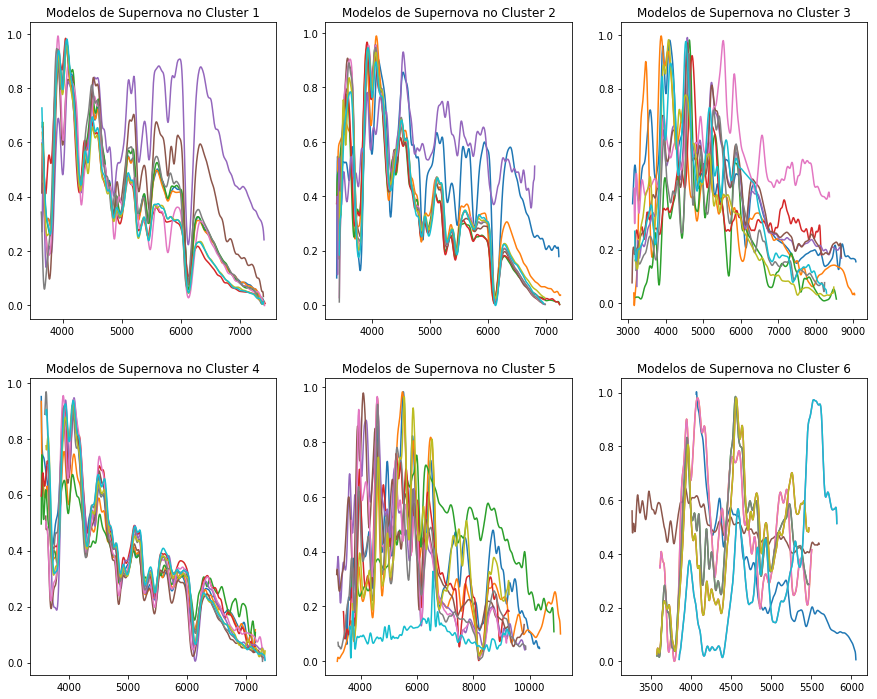

In [128]:
fig, axes = plt.subplots(nrows=2, ncols=3)
for i in range(10):
    axes[0,0].plot(dataFrame_kmeans_I.loc[dataCluster_0[i],'SNx'],dataFrame_kmeans_I.loc[dataCluster_0[i],'SNy'])
    axes[0,1].plot(dataFrame_kmeans_I.loc[dataCluster_1[i],'SNx'],dataFrame_kmeans_I.loc[dataCluster_1[i],'SNy'])
    axes[0,2].plot(dataFrame_kmeans_I.loc[dataCluster_2[i],'SNx'],dataFrame_kmeans_I.loc[dataCluster_2[i],'SNy'])
    axes[1,0].plot(dataFrame_kmeans_I.loc[dataCluster_3[i],'SNx'],dataFrame_kmeans_I.loc[dataCluster_3[i],'SNy'])
    axes[1,1].plot(dataFrame_kmeans_I.loc[dataCluster_4[i],'SNx'],dataFrame_kmeans_I.loc[dataCluster_4[i],'SNy'])
    axes[1,2].plot(dataFrame_kmeans_I.loc[dataCluster_5[i],'SNx'],dataFrame_kmeans_I.loc[dataCluster_5[i],'SNy'])
    
axes[0,0].set_title('Modelos de Supernova no Cluster 1')
axes[0,1].set_title('Modelos de Supernova no Cluster 2')
axes[0,2].set_title('Modelos de Supernova no Cluster 3')
axes[1,0].set_title('Modelos de Supernova no Cluster 4')
axes[1,1].set_title('Modelos de Supernova no Cluster 5')
axes[1,2].set_title('Modelos de Supernova no Cluster 6')

### Assim como no dataframe anterior este agrupamento não gerou bons modelos, pois os grupos demonstram-se muito diversificados, execeto pelo cluster 4. Desta forma outras tecnicas de agrupamento foram geradas

### O notebook de Agrupamento de dados pelo Dbscan indica uma alternativa de agrupamento com resultados melhores.